---
---
# Notebook: [ Week #05: RAG Advanced Retrieval and Evaluation ]

## Setup
---

In [1]:
!pip install openai --quiet
!pip install langchain --quiet
!pip install langchain_openai --quiet
!pip install langchain-community --quiet
!pip install unstructured --quiet
!pip install pdfminer --quiet
!pip install langchain-experimental --quiet
!pip install langchain_cohere --quiet
!pip install pysbd --quiet
!pip install ragas --quiet
!pip install pypdf --quiet
!pip install lolviz --quiet
!pip install chromadb --quiet
!pip install pdfminer.six --quiet
!pip install tiktoken --quiet
!pip install datasets --quiet
!pip install langchain-chroma --quiet



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ianwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ianwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ianwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ianwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\User

In [2]:
from openai import OpenAI
from getpass import getpass

API_KEY = getpass("Enter your OpenAI API Key")
client = OpenAI(api_key=API_KEY)

Enter your OpenAI API Key ········


---

## Helper Functions

---

In [115]:
def pretty_print(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

### Function for Generating Embedding

In [3]:
def get_embedding(input, model='text-embedding-3-small'):
    response = client.embeddings.create(
        input=input,
        model=model
    )
    return [x.embedding for x in response.data]

### Function for Text Generation

In [4]:
# This is the "Updated" helper function for calling LLM
def get_completion(prompt, model="gpt-4o-mini", temperature=0, top_p=1.0, max_tokens=256, n=1, json_output=False):
    if json_output == True:
      output_json_structure = {"type": "json_object"}
    else:
      output_json_structure = None

    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create( #originally was openai.chat.completions
        model=model,
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
        n=1,
        response_format=output_json_structure,
    )
    return response.choices[0].message.content

In [5]:
# This a "modified" helper function that we will discuss in this session
# Note that this function directly take in "messages" as the parameter.
def get_completion_by_messages(messages, model="gpt-4o-mini", temperature=0, top_p=1.0, max_tokens=1024, n=1):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
        n=1
    )
    return response.choices[0].message.content

### Functions for Token Counting

In [6]:
# This function is for calculating the tokens given the "message"
# ⚠️ This is simplified implementation that is good enough for a rough estimation

import tiktoken

def count_tokens(text):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    return len(encoding.encode(text))

def count_tokens_from_message_rough(messages):
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    value = ' '.join([x.get('content') for x in messages])
    return len(encoding.encode(value))


## Setting up Credentials & Common Components for LangChain

In [7]:
import os
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
os.environ["OPENAI_API_KEY"] = API_KEY

# embedding model that we will use for the session
embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

# llm to be used in RAG pipeplines in this notebook
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0, seed=42)

---
---

<br>

# Setting up a Naive RAG

![](https://d27l3jncscxhbx.cloudfront.net/lib/media/img-20240421132947558.png)

**\[ Overview of Steps in RAG \]**

- 1. **Document Loading**
	- In this initial step, relevant documents are ingested and prepared for further processing. This process typically occurs offline.
- 2. **Splitting & Chunking**
	- The text from the documents is split into smaller chunks or segments.
	- These chunks serve as the building blocks for subsequent stages.
- 3. **Storage**
	- The embeddings (vector representations) of these chunks are created and stored in a vector store.
	- These embeddings capture the semantic meaning of the text.
- 4. **Retrieval**
	- When an online query arrives, the system retrieves relevant chunks from the vector store based on the query.
	- This retrieval step ensures that the system identifies the most pertinent information.
- 5. **Output**
	- Finally, the retrieved chunks are used to generate a coherent response.
	- This output can be in the form of natural language text, summaries, or other relevant content.

![](https://abc-notes.data.tech.gov.sg/resources/img/topic-4-rag-overview.png)

## Importing Dependencies and Setting up

In [8]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [9]:
# Download and unzip into local folder
url = "https://abc-notes.data.tech.gov.sg/resources/data/notes.zip"

import requests
import zipfile
import io

response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()


## Document Loading

In [38]:
from langchain_community.document_loaders import TextLoader
path = r'D:\PersonalProjs\Govtech AI Course\notes\key_params_for_llms.txt'
loader = TextLoader(path, encoding='utf-8')
loader.load()

[Document(metadata={'source': 'D:\\PersonalProjs\\Govtech AI Course\\notes\\key_params_for_llms.txt'}, page_content='\n<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method.\n```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here.\n- ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are common fo

In [39]:
# list of filenames to load
filename_list = [
    '2. Key Parameters for LLMs.txt',
    '3. LLMs and Hallucinations.txt',
    '4. Prompting Techniques for Builders.txt',
]

# load the documents
list_of_documents_loaded = []
for filename in filename_list:
    try:
        # try to load the document
        markdown_path = os.path.join('notes', filename)
        loader = TextLoader(markdown_path, encoding='utf-8')

        # load() returns a list of Document objects
        data = loader.load()
        # use extend() to add to the list_of_documents_loaded
        list_of_documents_loaded.extend(data)
        print(f"Loaded {filename}")

    except Exception as e:
        # if there is an error loading the document, print the error and continue to the next document
        print(f"Error loading {filename}: {e}")
        continue

print("Total documents loaded:", len(list_of_documents_loaded))

Loaded 2. Key Parameters for LLMs.txt
Loaded 3. LLMs and Hallucinations.txt
Loaded 4. Prompting Techniques for Builders.txt
Total documents loaded: 3


## Splitting and Chunking

In [40]:
# See the first document loaded
list_of_documents_loaded[0]

Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='\n<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method.\n```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here.\n- ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are common for other LLMs, including **Open-S

In [41]:
list_of_documents_loaded[0].metadata.get("source")

'notes\\2. Key Parameters for LLMs.txt'

In [42]:
# With the understanding of the structure, we can now extract the page_content
# Check the number of tokens per document
i = 0
for doc in list_of_documents_loaded:
    i += 1
    print(f'Document {i} - "{doc.metadata.get("source")}" has {count_tokens(doc.page_content)} tokens')

Document 1 - "notes\2. Key Parameters for LLMs.txt" has 2569 tokens
Document 2 - "notes\3. LLMs and Hallucinations.txt" has 1040 tokens
Document 3 - "notes\4. Prompting Techniques for Builders.txt" has 4523 tokens


In [43]:
# While our document is not too long, we can still split it into smaller chunks
# This is to ensure that we can process the document in smaller chunks
# This is especially useful for long documents that may exceed the token limit
# or to keep the chunks smaller, so each chunk is more focused
from langchain_text_splitters import RecursiveCharacterTextSplitter

# In this case, we intentionally set the chunk_size to 1100 tokens, to have the smallest document (document 2) intact
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1100, chunk_overlap=10, length_function=count_tokens)

# Split the documents into smaller chunks
splitted_documents = text_splitter.split_documents(list_of_documents_loaded)

# Print the number of documents after splitting
print(f"Number of documents after splitting: {len(splitted_documents)}")

Number of documents after splitting: 9


In [44]:
from langchain_chroma import Chroma
# Create the vector database
vectordb = Chroma.from_documents(
    documents=splitted_documents,
    embedding=embeddings_model,
    collection_name="naive_splitter", # one database can have multiple collections
    persist_directory="./vector_db"
)

In [45]:
# Create the RAG pipeline
from langchain.chains import RetrievalQA

# The `llm` is defined earlier in the notebook (using GPT-4o-mini)
rag_chain = RetrievalQA.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [46]:
# Now we can use the RAG pipeline to ask questions
# Let's ask a question that we know is in the documents
llm_response = rag_chain.invoke('What is Top-P sampling?')
print(llm_response['result'])

Top-P sampling, also known as nucleus sampling, is a method used in language models to select the next word in a sequence based on probabilities. Instead of choosing the top K most probable words, Top-P sampling selects the smallest set of words whose cumulative probability exceeds a specified threshold P. The next word is then sampled from this set.

This approach allows for a more flexible selection of words, as it focuses on a subset of candidates that collectively have a high probability of being the next word, rather than being limited to a fixed number of top candidates. This can help balance diversity and coherence in the generated text.


In [47]:
# Now let's break down and see what are the "splitted_documents" that are used in the RAG pipeline
# We can do this by using the vectordb object that we have created
# k=4 is the default value for the number of retrieved documents
retrieved_documents = vectordb.similarity_search_with_relevance_scores("What is Top-P sampling?", k=4)


C:\Users\ianwa\AppData\Local\Temp\ipykernel_25976\3955048137.py:4: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='| Word      | Logits | Softmax | Softmax with LOW temperature | Softmax with High tempetaure |\n| --------- | ------ | ------- | ---------------------------- | :--------------------------- |\n| scenaries | 20     | 0.881   | 1.000                        | 0.8808                       |\n| buildings | 18     | 0.119   | 0.000                        | 0.1192                       |\n| people    | 5      | 0.000   | 0.000                        | 0.000                        |\n| gardens   | 2      | 0.000   | 0.000                        | 0.000                        |\n![](https://d17lzt44idt8rf.cloudfront.net/aicamp/resources/topic02/Pasted%20image%2020240328125030.png)\n\n> [!info] **[Extra]** The equations below shows how the "temperature" being incorporated into the Softma

In [48]:
retrieved_documents

[(Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='| Word      | Logits | Softmax | Softmax with LOW temperature | Softmax with High tempetaure |\n| --------- | ------ | ------- | ---------------------------- | :--------------------------- |\n| scenaries | 20     | 0.881   | 1.000                        | 0.8808                       |\n| buildings | 18     | 0.119   | 0.000                        | 0.1192                       |\n| people    | 5      | 0.000   | 0.000                        | 0.000                        |\n| gardens   | 2      | 0.000   | 0.000                        | 0.000                        |\n![](https://d17lzt44idt8rf.cloudfront.net/aicamp/resources/topic02/Pasted%20image%2020240328125030.png)\n\n> [!info] **[Extra]** The equations below shows how the "temperature" being incorporated into the Softmax function.\n> - 💡 You don\'t have to worry about understanding the equation or memorizing it. \n> - It\'s more for us to unde

In [49]:
# Display the first retrieved documents
# Feel free to change the index to see other retrieved documents
# Note that each of the documents is a tuple of (Document, relevance_score)
# the second [0] in [0][0] below is to get the Document object
print(retrieved_documents[0][0].page_content)

| Word      | Logits | Softmax | Softmax with LOW temperature | Softmax with High tempetaure |
| --------- | ------ | ------- | ---------------------------- | :--------------------------- |
| scenaries | 20     | 0.881   | 1.000                        | 0.8808                       |
| buildings | 18     | 0.119   | 0.000                        | 0.1192                       |
| people    | 5      | 0.000   | 0.000                        | 0.000                        |
| gardens   | 2      | 0.000   | 0.000                        | 0.000                        |
![](https://d17lzt44idt8rf.cloudfront.net/aicamp/resources/topic02/Pasted%20image%2020240328125030.png)

> [!info] **[Extra]** The equations below shows how the "temperature" being incorporated into the Softmax function.
> - 💡 You don't have to worry about understanding the equation or memorizing it. 
> - It's more for us to understand the intuition on where is the `temperature` being used
> 
> - **Softmax**
> $$ \text{Softmax

In [50]:
# Now we can use the RAG pipeline to ask questions
# Let's ask a question that we know is NOT in the documents
llm_response = rag_chain.invoke('What is an LLM Agent?')
print(llm_response['result'])

I don't know.


---

In [51]:
# Compared to the rag pipelines that we used above, this cell allows a custom prompt to be used
# This is useful for customizing the prompt to be used in the retrieval QA chain
# The prompt below is the standard template that is used in the retrieval QA chain
# It also includes the "documents" that are used in the prompt
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# Run chain
qa_chain = RetrievalQA.from_chain_type(
    ChatOpenAI(model='gpt-4o-mini'),
    retriever=vectordb.as_retriever(),
    return_source_documents=True, # Make inspection of document possible
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [52]:
qa_chain.invoke('How do i Prevent Prompt Injection & Hacking?')

{'query': 'How do i Prevent Prompt Injection & Hacking?',
 'result': 'To prevent prompt injection and hacking, use techniques like delimiters, XML-like tags, and post-prompting to safeguard user input. Additionally, consider employing the sandwich defense, where you place the user input between two prompts, and utilize a separate LLM to check for adversarial prompts. Thanks for asking!',
 'source_documents': [Document(metadata={'source': 'notes\\4. Prompting Techniques for Builders.txt'}, page_content='> [!tip] Tips: Get the dictionary\'s value with a failsafe\n> - ✦ When using `.get()` method to retrieve a value from Python dictionary, it can handle the "missing key" situation better, by returning a `None` or a default value if the key is not found in the dictionary.\n> - ✦ This can prevent KeyError exceptions which would occur with square bracket notation if the key is not found.\n\n- ✦ Extract the data from the `response` object\n```Python\nlist_of_hawkers = []\nif response_dict.get

---
---


# Techniques for Improving RAG Pipelines

RAG is only as good as the retrieved documents’ relevance and quality. Fortunately, an emerging set of techniques can be employed to design and improve RAG systems.

- The improvement of RAG is not just a matter of incremental updates, by installing newer Python package or calling any functions out-of-the-box, but many of them involves a comprehensive rethinking of its architecture and processes.

- We can group the various improvements under 3 major categories:
    - ✦ **Pre-Retrieval Processes**
    - ✦ **Retrieval Process**
    - ✦ **Post-Retrieval Process**

![](https://abc-notes.data.tech.gov.sg/notes/_resources/topic-5-advanced-rag/img-20240427230330556.png)

<small>Note: This categorization is intended for organizational purposes and may not be entirely precise. It's important to recognize that some techniques can impact multiple stages of the RAG process.</small>

---

- **How to use these techniques**?
    - Think of these techniques like Lego blocks – each one offers a unique function to improve the overall RAG system. The beauty lies in the experimentation, in building different combinations of these blocks to find the optimal configuration for a specific task.

    - There's no one-size-fits-all solution, no silver bullet recipe for success. The accuracy of a RAG system depends on a multitude of factors, including the structure of the documents, the nature of the questions, and even the specific dataset being used.

    - A combination that works wonders for one case might fall flat in another. The key is to embrace the modularity of these techniques and explore different configurations to find the perfect fit for your specific needs.




---
---
<br>


# Improving the Pre-Retrieval Process

---

## Semantic Chunking


- Semantic chunking relies heavily on embeddings, powerful tools for understanding text semantics.

- Despite their apparent simplicity, embeddings enable the comparison of different text segments and the identification of underlying relationships.

- Here’s how semantic chunking works in practice:
    - Text segments with similar meanings are grouped together.
    - Leveraging embeddings, we analyze and group consecutive sentences within a specified window size.
    - Beginning with the initial sentence, we compare its embedding to the subsequent sentences, iterating through the text until a significant deviation is detected, indicating a potential break point.
    - Continuously computing embeddings within each sentence set allows for dynamic adjustments, refining the grouping process and enhancing our understanding of the text’s meaning.
    - Through this method, we identify coherent groups of sentences that form meaningful sections, aiding in analysis and comprehension.
- The easiest way to take advantage of this cutting-edge chunking approach is to use Langchain's experimental module:

In [53]:
from langchain_experimental.text_splitter import SemanticChunker

# Create the text splitter
text_splitter = SemanticChunker(embeddings_model)

# Split the documents into smaller chunks
splitted_documents = text_splitter.split_documents(list_of_documents_loaded)


In [55]:
# View the first splitted document
# Feel free to change the index to see other splitted documents
# Check where the split is done
import pprint

pprint.pprint(dict(splitted_documents[1]))

{'id': None,
 'metadata': {'source': 'notes\\2. Key Parameters for LLMs.txt'},
 'page_content': 'It’s akin to setting how “creative” or “safe” you want the '
                 'model’s responses to be. - **✦ Technically, it adjusts the '
                 'probability distribution of the next token** being '
                 'generated, influencing the diversity of the generated text\n'
                 '\t- `Softmax function` is often used in machine learning '
                 'models to convert raw scores (also known as logits) into '
                 'probabilities. - In the context of language models, the '
                 'softmax function is used to convert the scores assigned to '
                 'each possible next word into probabilities. The word with '
                 'the highest probability is often chosen as the prediction. - '
                 'So, if the softmax value for a word is high, it means that '
                 'the model predicts that word to be the next wor

In [56]:
# Apparently, the concept "Temperature" has been split into two different chunks
import pprint

pprint.pprint(dict(splitted_documents[1]))

{'id': None,
 'metadata': {'source': 'notes\\2. Key Parameters for LLMs.txt'},
 'page_content': 'It’s akin to setting how “creative” or “safe” you want the '
                 'model’s responses to be. - **✦ Technically, it adjusts the '
                 'probability distribution of the next token** being '
                 'generated, influencing the diversity of the generated text\n'
                 '\t- `Softmax function` is often used in machine learning '
                 'models to convert raw scores (also known as logits) into '
                 'probabilities. - In the context of language models, the '
                 'softmax function is used to convert the scores assigned to '
                 'each possible next word into probabilities. The word with '
                 'the highest probability is often chosen as the prediction. - '
                 'So, if the softmax value for a word is high, it means that '
                 'the model predicts that word to be the next wor

In [57]:
# Embed each chunk and load it into the vector store.
vectordb = Chroma.from_documents(splitted_documents, embeddings_model, collection_name='embedding_semantic', persist_directory='./vector_db')

In [58]:
# Create a Q&A Chain (Pipeline) using LangChain
from langchain.chains import RetrievalQA


retriever_chain_from_llm = RetrievalQA.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [59]:
# Let's see if the LLM can answer the question "What is Temperature in LLMs?" well
retriever_chain_from_llm.invoke('What is Temperature in LLMs?')

{'query': 'What is Temperature in LLMs?',
 'result': 'In the context of Large Language Models (LLMs), "temperature" refers to a parameter that controls the randomness of the model’s predictions. A high temperature setting makes the model more likely to produce varied and sometimes unexpected responses, while a low temperature results in more predictable and conservative outputs. Essentially, it adjusts the probability distribution of the next token being generated, influencing the diversity of the generated text.'}

In [60]:
# In this result, you can see the second chunk of the "Temperature" concept is retrieved but at the last position
# This is still fine since all the chunks are retrieved and passed to the LLM for answering the question
vectordb.similarity_search_with_relevance_scores('What is Temperature in LLMs?', k=4)

[(Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='\n<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method. ```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here. - ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are common for other LLMs, including **Open-S

> 💡 Try with different questions for the cell above.

---
---

## Multi Query Retrieval

- If query is complex and having multiple context then, retrieval with the single query may not be the good approach as it may fail to get proper output.

- In LangChain, the `MultiQueryRetriever` automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query.

- For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents.

- By generating multiple perspectives on the same question, the `MultiQueryRetriever` might be able to overcome some of the limitations of the distance-based retrieval and get a richer set of results.

- Below is a sample implementation using MultiQueryRetriever

In [61]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI


# We will be reusing the `vectordb` from the Naive RAG
# You can imagine `MultiQueryRetriever` as a chain that generates multiple queries
# itself is not a complete RAG chain, but it can be used as a retriever in a RAG chain
retriever_multiquery = MultiQueryRetriever.from_llm(
  retriever=vectordb.as_retriever(), llm=llm,
)

---

Let's peek into the `MultiQueryRetriever` class to understand how it works.

In [62]:
# Set logging for the queries
import logging

# Refer to LangChain documentation to find which loggers to set
# Different LangChain Classes/Modules have different loggers to set
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [63]:
question = "What is Temperature in LLMs?"

unique_docs = retriever_multiquery.invoke(question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['What does the term "temperature" refer to in the context of large language models (LLMs)?', 'How does temperature affect the output of large language models?', 'Can you explain the role of temperature in the functioning of LLMs?']


5

In [64]:
# Create the compplete Q&A Chain (Pipeline)
from langchain.chains import RetrievalQA

# Note that the `retriever_multiquery` is used as the retriever
# rather than the `vectordb` and its as_retriever() method that we used in the previous examples
qa_chain_multiquery= RetrievalQA.from_llm(
    retriever=retriever_multiquery, llm=llm
)

In [66]:
# The first output lists the various queries that are generated
qa_chain_multiquery.invoke("What is the temperature of the sun?")

INFO:langchain.retrievers.multi_query:Generated queries: ['What is the surface temperature of the sun in degrees Celsius?  ', 'How hot is the sun compared to other stars in the universe?  ', "Can you provide information on the sun's core temperature and its effects?"]


{'query': 'What is the temperature of the sun?', 'result': "I don't know."}

<br>

### 🔷 Challenge 1
- Use OpenAI LLM to improve the user query first, before passing the LLM-improved query into the `qa_chain_multiquery` above.
- What will be the `prompt` that you will use?

In [67]:
def improved_qn(qn):
    prompt=get_completion(f"""\
    You are an AI language model assistant. Your task is to improve the \
    clarity of the given question by the user, enclosed by a pair of <user_question>.\  
    If it is relevant, first state the objective of the user.\
    If question is unclear, provide some guiding questions to the user to follow, and then from there\
    provide a context or definition  
    Original question: <user_question>{question}</user_question>""")
    qa_chain_multiquery= RetrievalQA.from_llm(
    retriever=retriever_multiquery, llm=llm
    )
    return qa_chain_multiquery.invoke(prompt)

improved_qn("What is the temperature of the sun?")

INFO:langchain.retrievers.multi_query:Generated queries: ['What is the role of temperature in shaping the responses generated by large language models?', 'How does adjusting the temperature parameter impact the creativity and variability of outputs in LLMs?', 'Can you explain how temperature settings can be utilized effectively when working with large language models?']


{'query': 'The objective of the user seems to be to understand the concept of "temperature" as it relates to large language models (LLMs). \n\nTo clarify the question, here are some guiding questions you might consider:  \n1. Are you asking about the technical definition of temperature in the context of LLMs?  \n2. Do you want to know how temperature affects the output of a language model?  \n3. Are you interested in practical applications of temperature settings when using LLMs?  \n\n**Context/Definition:**  \nIn the context of large language models, "temperature" is a parameter that controls the randomness of the model\'s predictions. A lower temperature (e.g., close to 0) makes the model more deterministic, leading to more predictable and conservative outputs. Conversely, a higher temperature (e.g., above 1) increases randomness, allowing for more diverse and creative responses. Understanding how temperature influences the generation of text can help you tailor the model\'s output t

---
---


# Improving the Retrieval Process

![](https://abc-notes.data.tech.gov.sg/notes/_resources/topic-5-advanced-rag/img-20240427225235075.png)

---

## Maximum Marginal Relevance (MMR)

In the domain of information retrieval and text summarization, the challenge often lies in finding a balance between relevance and diversity. This is where Maximum Marginal Relevance (MMR) comes into play.
- MMR is based on the idea that while retrieving information or summarizing text, one should not only focus on the relevance of the content but also on how different the selected items are from each other.
- This helps in reducing redundancy and improving the overall quality of the retrieved information or summary.

In [68]:
# In this exampe, we will take a pause from the previous documents (notes from AI Champions Bootcamp).
# We will work with a new set of texts, which able to better demonstrate the issues that MMR can solve

texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]


### Ordinary Similarity-based Retrieval (Fail!!)

In [69]:
# Embed each chunk and load it into the vector store.
vectordb = Chroma.from_texts(texts, embeddings_model, collection_name='mushroom')

print(vectordb._collection.count())


# Let's see the underlying documents that are used in the retrieval QA chain
# This time, instead of using vectordb.similarity_search_with_relevance_scores
# we use the `retriever` object that is created from the `vectordb`
# `retriever` is a high-level object that is used in the retrieval QA chain
# It supports more features and allow us to modify the retrieval process,
# including MMR, set the similarity threshold, and more

retriever = vectordb.as_retriever(search_kwargs={'k': 2})

retriever_documents = retriever.invoke('Tell me about all-white mushrooms with large fruiting bodies')

# Note that while the documents are retrieved to maximize the relevance,
# the 3rd document is not retrieved as it is not relevant to the query,
# but yet it contains a critical piecce of information to be included in the answer
retriever_documents

3


[Document(metadata={}, page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(metadata={}, page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

In [72]:
# Create the complete Q&A Chain (Pipeline)
from langchain.chains import RetrievalQA

qa_chain_mushroom = RetrievalQA.from_llm(
    retriever=retriever, llm=llm
)

In [73]:
question = "Tell me about white mushrooms with large fruiting bodies."

# Note that fact that the mushroom might be poisonous is not included in the retrieved documents
# and are not included in the answer
qa_chain_mushroom.invoke(question)

{'query': 'Tell me about white mushrooms with large fruiting bodies.',
 'result': "One example of a white mushroom with a large fruiting body is the Amanita phalloides, also known as the death cap mushroom. Some varieties of this mushroom are all-white and have a large and imposing aboveground fruiting body. However, I don't have more specific information about other white mushrooms with large fruiting bodies."}

### MMR-based Search

In [74]:
# Note that we do not have to change the vector database to use MMR
# We can use the `retriever` object to set the MMR parameters
# The MMR is a built-in feature in the `retriever` object for some vector stores

# Remember that the `retriever` object is a high-level object that is used in the retrieval QA chain
retriever = vectordb.as_retriever(search_type='mmr',
                                  search_kwargs={'k': 2, 'fetch_k': 3})

retriever_documents = retriever.invoke('Tell me about all-white mushrooms with large fruiting bodies')

# Note that due to the MMR, the 3rd document is now retrieved,
# as MMR introduces diversity in the retrieved documents.
# Of course in actual cases, we will use larger `fetch_k`
# and reasonable 'k' values to get more diverse documents and sufficient context
retriever_documents

[Document(metadata={}, page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(metadata={}, page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

In [75]:
question = "Tell me about white mushrooms with large fruiting bodies."

# Note that now the response includes the fact that the mushroom is poisonous

qa_chain_mushroom = RetrievalQA.from_llm(
    retriever=retriever, llm=llm
)
qa_chain_mushroom.invoke(question)

{'query': 'Tell me about white mushrooms with large fruiting bodies.',
 'result': "One type of white mushroom with a large fruiting body is the Amanita phalloides, also known as the death cap mushroom. Some varieties of this mushroom are all-white and have a large and imposing aboveground fruiting body. However, it's important to note that Amanita phalloides is highly toxic and can be deadly if consumed. If you are looking for information on other types of white mushrooms with large fruiting bodies, I don't know."}

> 💡**OPTIONAL: If you're keen to find out more on how to use `as_retriever()` method, click the link below:

<details>
<summary><font size="2" color="darkgreen"><b>👆🏼 Click to for find out)</b></font></summary>

<small>
The term np.max(logits) is subtracted from logits to avoid numerical instability that can occur when taking the exponential of large numbers, a common issue in machine learning computations.

Here's why: the softmax function involves taking the exponential of each logit. If a logit is a large positive number, its exponential can be extremely large - so large that it exceeds the maximum representable number (overflow), leading to inf values. This can cause the softmax function to return incorrect results.

By subtracting np.max(logits), we ensure that the maximum value in the logits array is 0, which means the largest possible output from the exponential function is 1. This effectively eliminates the possibility of overflow.

Importantly, this operation doesn't change the output of the softmax function. That's because softmax is shift invariant, meaning that adding or subtracting a constant from each logit doesn't affect the output probabilities. This property allows us to subtract the maximum logit for numerical stability without changing the function's output.


### **Documentation for `as_retriever()` method**

- Signature: vectordb.as_retriever(**kwargs: 'Any') -> 'VectorStoreRetriever'

- Docstring:
    - Return VectorStoreRetriever initialized from this VectorStore.

- Args:
    - **kwargs: Keyword arguments to pass to the search function.
        - Can include:
        - `search_type` (Optional[str]): Defines the type of search that
            the Retriever should perform.
            Can be "similarity" (default), "mmr", or
            "similarity_score_threshold".
        - `search_kwargs` (Optional[Dict]): Keyword arguments to pass to the
            search function. Can include things like:
            - `k`: Amount of documents to return (Default: 4)
            - `score_threshold`: Minimum relevance threshold for similarity_score_threshold
            - `fetch_k`: Amount of documents to pass to MMR algorithm (Default: 20)
            - `lambda_mult`: Diversity of results returned by MMR; 1 for minimum diversity and 0 for maximum. (Default: 0.5)
            - `filter`: Filter by document metadata

- Returns:
    VectorStoreRetriever: Retriever class for VectorStore.

- Examples:

```Python

    # Retrieve more documents with higher diversity
    # Useful if your dataset has many similar documents
    docsearch.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 6, 'lambda_mult': 0.25}
    )

    # Fetch more documents for the MMR algorithm to consider
    # But only return the top 5
    docsearch.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 5, 'fetch_k': 50}
    )

    # Only retrieve documents that have a relevance score
    # Above a certain threshold
    docsearch.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={'score_threshold': 0.8}
    )

    # Only get the single most similar document from the dataset
    docsearch.as_retriever(search_kwargs={'k': 1})

    # Use a filter to only retrieve documents from a specific paper
    docsearch.as_retriever(
        search_kwargs={'filter': {'paper_title':'GPT-4 Technical Report'}}
    )
```
</small>
</details>

<br>

---

## Parent Child Index Retrieval

When splitting documents for retrieval, there are often conflicting desires:

You may want to have small documents, so that their embeddings can most accurately reflect their meaning. If too long, then the embeddings can lose meaning.
You want to have long enough documents that the context of each chunk is retained.
The ParentDocumentRetriever strikes that balance by splitting and storing small chunks of data. During retrieval, it first fetches the small chunks but then looks up the parent ids for those chunks and returns those larger documents.

Note that "parent document" refers to the document that a small chunk originated from. This can either be the whole raw document OR a larger chunk.

In [76]:
# Since we are trying out different examples in this notebook
# This is to reset the collection in the vector store to have a clean slate
vectordb.reset_collection()
vectordb._collection.count()

0

In [77]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

In [78]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(separators=["\n# "], chunk_size=4000, length_function=count_tokens)

# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(separators=["\n## "], chunk_size=1250, length_function=count_tokens)

# The vectorstore to use to index the child chunks
vectordb = Chroma(collection_name="parent_child", embedding_function=embeddings_model)

# The storage layer for the parent documents
store = InMemoryStore()

# Specificy a Retriever
retriever = ParentDocumentRetriever(
    vectorstore=vectordb,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={'k': 4} # k = 4 means that it will return the 4 most similar docs to the input query
)

# The splitting & embeddings happen
retriever.add_documents(list_of_documents_loaded)

In [79]:
# The documents are indexed
# 4 parents because the last document is split into 2 parts
store.store

{'e97a74d2-f111-420a-a2af-3c3af75d7b0a': Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method.\n```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here.\n- ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are co

In [80]:
# Get all records in vector store
vectordb._collection.count()

9

In [81]:
# Rely on the vectorstore to retrieve all the documents (which we are familiar with)
# That that there are 9 child documents
vectordb.similarity_search_with_relevance_scores("What is Top-P sampling?", k=15)

# Alternatively, we can use
# vectordb._collection.peek()

C:\Users\ianwa\AppData\Local\Temp\ipykernel_25976\2034858280.py:3: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'doc_id': 'e97a74d2-f111-420a-a2af-3c3af75d7b0a', 'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='\n## Temperature\n![](https://images.unsplash.com/photo-1602096675810-9dce30949e80?q=80&w=2041&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)\n\n- ✦ In the context of Large Language Models (LLMs) like GPT3.5 or GPT-4o, “temperature” refers to a parameter that **controls the randomness of the model’s predictions.** \n\t- When you set a high temperature, the model is more likely to produce varied and sometimes unexpected responses. \n\t- Conversely, a low temperature results in more predictable and conservative outputs. It’s akin to setting how “creative” or “safe” you want the model’s responses to be. \n\n\n- **✦ Technically, it adjusts the probability distribution of the next toke

[(Document(metadata={'doc_id': 'e97a74d2-f111-420a-a2af-3c3af75d7b0a', 'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='\n## Temperature\n![](https://images.unsplash.com/photo-1602096675810-9dce30949e80?q=80&w=2041&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)\n\n- ✦ In the context of Large Language Models (LLMs) like GPT3.5 or GPT-4o, “temperature” refers to a parameter that **controls the randomness of the model’s predictions.** \n\t- When you set a high temperature, the model is more likely to produce varied and sometimes unexpected responses. \n\t- Conversely, a low temperature results in more predictable and conservative outputs. It’s akin to setting how “creative” or “safe” you want the model’s responses to be. \n\n\n- **✦ Technically, it adjusts the probability distribution of the next token** being generated, influencing the diversity of the generated text\n\t- `Softmax function` is often used in machine learning

In [82]:
# We use the underlying vector store to retrieves the small chunks.
sub_docs = vectordb.similarity_search('What is Top-P sampling?')
sub_docs

[Document(metadata={'doc_id': 'e97a74d2-f111-420a-a2af-3c3af75d7b0a', 'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='\n## Temperature\n![](https://images.unsplash.com/photo-1602096675810-9dce30949e80?q=80&w=2041&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)\n\n- ✦ In the context of Large Language Models (LLMs) like GPT3.5 or GPT-4o, “temperature” refers to a parameter that **controls the randomness of the model’s predictions.** \n\t- When you set a high temperature, the model is more likely to produce varied and sometimes unexpected responses. \n\t- Conversely, a low temperature results in more predictable and conservative outputs. It’s akin to setting how “creative” or “safe” you want the model’s responses to be. \n\n\n- **✦ Technically, it adjusts the probability distribution of the next token** being generated, influencing the diversity of the generated text\n\t- `Softmax function` is often used in machine learning 

In [83]:
# This is the parent-level retriever that returns the parent documents (the larger chunks)
retrieved_docs = retriever.invoke('What is Top-P sampling?')
retrieved_docs

[Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method.\n```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here.\n- ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are common for other LLMs, including **Open-So

> For this technique, we will skip the complete RAG Pipeline creation.

---
---
<br>



### Query Translater
✦ This is a module in charge of translating the output of the LLM (Query Constructor) into the appropriate format to perform the query. 
Depending on the vector database you use, you may have to use different types of query translators.
As usual, we will use Chroma db, therefore, we need a translator built specifically for this database. LangChain has specific database translators for almost all of the databases.

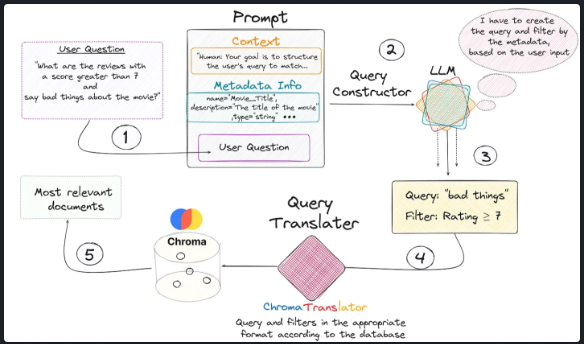


✦ From the previous image, we see that everything begins with the user’s query.

We create the prompt that contains the 3 key fields and is introduced to the LLM that generates a response with two key fields: “Query” and “Filter”.
This is fed into the query translator which translates these two fields into the correct format needed by Chroma DB. 
Performs the query and returns the most relevant documents based on the user’s initial question.


✦ It is very important to provide the LLM with a detailed description of the metadata available in the vector store. This is shown through the following piece of code:

In [84]:
from langchain_chroma import Chroma  
from langchain_core.documents import Document  
from langchain_openai import OpenAIEmbeddings  
  
docs = [  
	Document(  
		page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",  
		metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},  
		),  
	Document(  
		page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",  
		metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},  
	),  
	Document(  
		page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",  
		metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},  
	),  
	Document(  
		page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",  
		metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},  
	),  
	Document(  
		page_content="Toys come alive and have a blast doing so",  
		metadata={"year": 1995, "genre": "animated"},  
		),  
	Document(  
		page_content="Three men walk into the Zone, three men walk out of the Zone",  
		metadata={  
			"year": 1979,  
			"director": "Andrei Tarkovsky",  
			"genre": "thriller",  
			"rating": 9.9,  
			},  
	),  
]  
vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())


✦ Now we can instantiate our retriever.
To do this we’ll need to provide some information upfront about the metadata fields that our documents support and a short description of the document contents.

In [87]:
!pip install lark


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ianwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [88]:
from langchain.chains.query_constructor.base import AttributeInfo  
from langchain.retrievers.self_query.base import SelfQueryRetriever  
from langchain.retrievers.self_query.chroma import ChromaTranslator
from langchain_openai import ChatOpenAI
  
metadata_field_info = [  
	AttributeInfo(  
		name="genre",  
		description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",  
		type="string",  
	),  
	AttributeInfo(  
		name="year",  
		description="The year the movie was released",  
		type="integer",  
	),  
	AttributeInfo(  
		name="director",  
		description="The name of the movie director",  
		type="string",  
	),  
	AttributeInfo(  
		name="rating", description="A 1-10 rating for the movie", type="float"  
	),  
]  

document_content_description = "Brief summary of a movie"  

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")  
chat_model = ChatOpenAI()  
  
self_query_retriever = SelfQueryRetriever.from_llm(  
	llm=ChatOpenAI(temperature=0),  
	vectorstore =vectordb,  
	document_contents = document_content_description,  
	metadata_field_info =metadata_field_info,  
	verbose = True,  
	structured_query_translator = ChromaTranslator()  
	)


ImportError: Cannot import lark, please install it with 'pip install lark'.

# Improving Post-Retrieval Processes

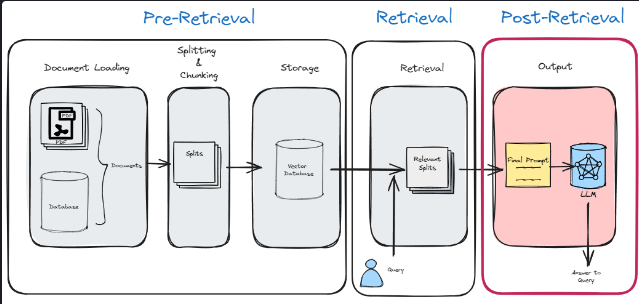

## Filtering by Score Threshold
- This is a process of filtering out the chunks based on the similarity score.
- We can set threshold for filtering.
- Filtering removes noise and redundant information and passes only relevant context to LLM, which improves generation quality.

For this demonstration, we will use the Naive Retriever.
We recreate the vectordb here again, so we won't have to scroll up and refer to the earlier code.


In [89]:
# Reset the collection in the vector store to have a clean slate
vectordb.reset_collection()
vectordb._collection.count()

0

In [95]:
# list of filenames to load
filename_list = [
    '2. Key Parameters for LLMs.txt',
    '3. LLMs and Hallucinations.txt',
    '4. Prompting Techniques for Builders.txt',
]

# load the documents
list_of_documents_loaded = []
for filename in filename_list:
    try:
        # try to load the document
        markdown_path = os.path.join('notes', filename)
        loader = TextLoader(markdown_path, encoding='utf-8')

        # load() returns a list of Document objects
        data = loader.load()
        # use extend() to add to the list_of_documents_loaded
        list_of_documents_loaded.extend(data)
        print(f"Loaded {filename}")

    except Exception as e:
        # if there is an error loading the document, print the error and continue to the next document
        print(f"Error loading {filename}: {e}")
        continue

print("Total documents loaded:", len(list_of_documents_loaded))

Loaded 2. Key Parameters for LLMs.txt
Loaded 3. LLMs and Hallucinations.txt
Loaded 4. Prompting Techniques for Builders.txt
Total documents loaded: 3


In [96]:
# While our document is not too long, we can still split it into smaller chunks
# This is to ensure that we can process the document in smaller chunks
# This is especially useful for long documents that may exceed the token limit
# or to keep the chunks smaller, so each chunk is more focused
from langchain_text_splitters import RecursiveCharacterTextSplitter

# In this case, we intentionally set the chunk_size to 1100 tokens, to have the smallest document (document 2) intact
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1100, chunk_overlap=10, length_function=count_tokens)

# Split the documents into smaller chunks
splitted_documents = text_splitter.split_documents(list_of_documents_loaded)

# Print the number of documents after splitting
print(f"Number of documents after splitting: {len(splitted_documents)}")

Number of documents after splitting: 9


In [97]:
from langchain_chroma import Chroma
# Create the vector database
vectordb = Chroma.from_documents(
    documents=splitted_documents,
    embedding=embeddings_model,
    collection_name="splitter_threshold", # one database can have multiple collections
    persist_directory="./vector_db"
)

In [98]:
# Create the RAG pipeline
from langchain.chains import RetrievalQA


# ⚠️⚠️⚠️ This is the key step
# We can set the threshold for the retriever, this is the minimum similarity score for the retrieved documents
retriever_w_threshold = vectordb.as_retriever(
        search_type="similarity_score_threshold",
        # There is no universal threshold, it depends on the use case
        search_kwargs={'score_threshold': 0.20}
    )
# The `llm` is defined earlier in the notebook (using GPT-4o-mini)
rag_chain = RetrievalQA.from_llm(
    retriever=retriever_w_threshold, llm=llm
)

In [99]:
# Now we can use the RAG pipeline to ask questions
# Let's ask a question that we know is in the documents
llm_response = rag_chain.invoke('What is Temperature in LLMs?')
print(llm_response['result'])

In the context of Large Language Models (LLMs), "temperature" refers to a parameter that controls the randomness of the model’s predictions. A high temperature setting makes the model more likely to produce varied and sometimes unexpected responses, while a low temperature results in more predictable and conservative outputs. Essentially, it adjusts the probability distribution of the next token being generated, influencing the diversity of the generated text. 

At lower temperatures, the model's predictions are more deterministic, favoring the most likely next token, whereas at higher temperatures, the probabilities are more evenly distributed, leading to more randomness and creativity in the generated text.


In [100]:
# Use the high-level retriever object to retrieve the relevant documents
retriever_w_threshold.invoke('What is Temperature in LLMs?')

[Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method.\n```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here.\n- ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are common for other LLMs, including **Open-So

In [101]:
# Use the low-level vectorstore to see the retrieved documents with the relevance scores
# Note that the `score_threshold` does not affect the vectorstore, it only affects the retriever
vectordb.similarity_search_with_relevance_scores('What is Temperature in LLMs?', k=4)

[(Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='<h1>Title: Key Parameters for LLMs</h1>\n\n# Key Parameters for LLMs\n- ✦ For our `Helper Function` in the notebook, we only pass in three arguments to the `create()` method.\n```Python\n# This is a function that send input (i.e., prompt) to LLM and receive the output from the LLM\ndef get_completion(prompt, model="gpt-4o-mini"):\n    messages = [{"role": "user", "content": prompt}]\n    response = client.chat.completions.create(\n        model=model,\n        messages=messages,\n        temperature=0, # this is the degree of randomness of the model\'s output\n    )\n```\n\n- ✦ The method can accept more parameters than we are using here.\n- ✦ There are three essential parameters here that can directly affect the behaviour of the LLMs. They are:\n\t  **- Temperature**\n\t  **- Top-P**\n\t  **- Top-K (not available on OpenAI models)**\n- ✦ These parameters are common for other LLMs, including **Open-S

### Using Contextual Compression
To use the Contextual Compression Retriever, you need
- ```a basic retriever```
- ```a document compressor```
The Contextual Compression Retriever passes queries to the Base Retriever, takes the source docs and forwards them to the Doc Compressor.
The ```Document Compressor``` takes a list of docs and shortens them by reducing the content, or omitting them altogether.

In [106]:
vectorstore = Chroma(
    collection_name="contextual_compression",
    embedding_function=embeddings_model,
)
vectorstore.add_documents(list_of_documents_loaded)
retriever = vectorstore.as_retriever()
print(question)
retriever.get_relevant_documents(query=question)

Tell me about white mushrooms with large fruiting bodies.


[Document(metadata={'source': 'notes\\3. LLMs and Hallucinations.txt'}, page_content='\n\n<h1>Title: LLMs and Hallucinations</h1>\n\n\n# LLMs & Hallucinations\n- ✦ One important thing to take note of when using such AI powered by Large Language Models (LLMs) is that they often generate text that appears coherent and contextually relevant but is factually incorrect or misleading. \n\t- We call these **hallucination problems**. This issue arises due to the inherent nature of how LLMs are trained and their reliance on massive datasets. \n\t- While some of the models like ChatGPT go through a second phase in the training where humans try to improve the responses, there is generally no fact-checking mechanism that is built into these LLMs when you use them.\n\n- ✦ There is no easy foolproof safeguard against hallucination, although some system prompt engineering can help mitigate this. \n\t- What makes hallucination by LLM worse is that the responses are surprisingly real, even if they are 

In [108]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
compressed_docs

[]

### Another way to do Context Compression

✦ Prompt Compression is a method of compressing or shrinking BOTH the retrieved context or final prompt by removing irrelevant information.
- Its aim is to reduce length of the input prompt to reduce cost, improve latency and efficiency of output generation by allowing the LLM to focus on a more concise context.
- The core idea is to use LLM to generate compressed version of input prompt.

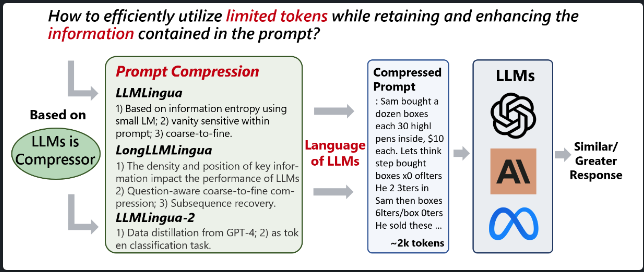

✦ Based on information on the repository, it was claimed that these tools offer an efficient solution to compress prompts by up to 20x, enhancing the utility of LLMs.
- 💰 Cost Savings: Reduces both prompt and generation lengths with minimal overhead.
- 📝 Extended Context Support: Enhances support for longer contexts, mitigates the "lost in the middle" issue, and boosts overall performance.
- ⚖️ Robustness: No additional training needed for LLMs.
- 🕵️ Knowledge Retention: Maintains original prompt information like ICL and reasoning.
- 📜 KV-Cache Compression: Accelerates inference process.
- 🪃 Comprehensive Recovery: GPT-4 can recover all key information from compressed prompts.


In [109]:
!pip install llmlingua

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   --------------------------------- ------ 8.4/10.0 MB 43.5 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 44.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ianwa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [110]:
from llmlingua import PromptCompressor

llm_lingua = PromptCompressor()
compressed_prompt = llm_lingua.compress_prompt(prompt, instruction="", question="", target_token=200)
compressed_prompt

C:\Users\ianwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ianwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ianwa\.cache\huggingface\hub\models--NousResearch--Llama-2-7b-hf. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggi

AssertionError: Torch not compiled with CUDA enabled

> 💡**OPTIONAL: If you're keen to find out more parameters that can be used in `as_retriever()` method, click the link below:

<details>
<summary><font size="2" color="darkgreen"><b>👆🏼 Click to for find out)</b></font></summary>

<small>
The term np.max(logits) is subtracted from logits to avoid numerical instability that can occur when taking the exponential of large numbers, a common issue in machine learning computations.

Here's why: the softmax function involves taking the exponential of each logit. If a logit is a large positive number, its exponential can be extremely large - so large that it exceeds the maximum representable number (overflow), leading to inf values. This can cause the softmax function to return incorrect results.

By subtracting np.max(logits), we ensure that the maximum value in the logits array is 0, which means the largest possible output from the exponential function is 1. This effectively eliminates the possibility of overflow.

Importantly, this operation doesn't change the output of the softmax function. That's because softmax is shift invariant, meaning that adding or subtracting a constant from each logit doesn't affect the output probabilities. This property allows us to subtract the maximum logit for numerical stability without changing the function's output.


### **Documentation for `as_retriever()` method**

- Signature: vectordb.as_retriever(**kwargs: 'Any') -> 'VectorStoreRetriever'

- Docstring:
    - Return VectorStoreRetriever initialized from this VectorStore.

- Args:
    - **kwargs: Keyword arguments to pass to the search function.
        - Can include:
        - `search_type` (Optional[str]): Defines the type of search that
            the Retriever should perform.
            Can be "similarity" (default), "mmr", or
            "similarity_score_threshold".
        - `search_kwargs` (Optional[Dict]): Keyword arguments to pass to the
            search function. Can include things like:
            - `k`: Amount of documents to return (Default: 4)
            - `score_threshold`: Minimum relevance threshold for similarity_score_threshold
            - `fetch_k`: Amount of documents to pass to MMR algorithm (Default: 20)
            - `lambda_mult`: Diversity of results returned by MMR; 1 for minimum diversity and 0 for maximum. (Default: 0.5)
            - `filter`: Filter by document metadata

- Returns:
    VectorStoreRetriever: Retriever class for VectorStore.

- Examples:

```Python

    # Retrieve more documents with higher diversity
    # Useful if your dataset has many similar documents
    docsearch.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 6, 'lambda_mult': 0.25}
    )

    # Fetch more documents for the MMR algorithm to consider
    # But only return the top 5
    docsearch.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 5, 'fetch_k': 50}
    )

    # Only retrieve documents that have a relevance score
    # Above a certain threshold
    docsearch.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={'score_threshold': 0.8}
    )

    # Only get the single most similar document from the dataset
    docsearch.as_retriever(search_kwargs={'k': 1})

    # Use a filter to only retrieve documents from a specific paper
    docsearch.as_retriever(
        search_kwargs={'filter': {'paper_title':'GPT-4 Technical Report'}}
    )
```
</small>
</details>

## Cross-encoder Re-ranking

- If you wish to go through this part, you will need to create an account on https://dashboard.cohere.com/.
- After creating the account, go to `API Keys` from the left panel, then copy your API key inder the `Trial Keys` section
- The whole process from account registration to get the API Key should be about 3 minutes.
-

In [ ]:
cohere_api_key = getpass("Enter your cohere key")

In [ ]:
from langchain_cohere import CohereRerank
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever

os.environ["COHERE_API_KEY"] = cohere_api_key

compressor = CohereRerank(top_n=3, model='rerank-english-v3.0')

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(),

)

In [ ]:
# Test and examine retrieved documents from the retriever
query = "What is Temperature in LLMs?"
docs = compression_retriever.invoke(query)
docs

In [ ]:
logging.getLogger("langchain.retrievers.contextual_compression").setLevel(logging.DEBUG)

In [ ]:
# Using the retriever in a Q&A Chain
retriever_from_llm_naive = RetrievalQA.from_llm(
    retriever=compression_retriever, llm=llm
)
retriever_from_llm_naive.invoke('What is Temperature in LLMs?')

---
---

# Evaluating RAG Output

- For this part, we will be using the `answer` from LLM generated previous on the `question`
- "What is Temperature in LLMs?" to emulate the ground truth for the `question`.
Ideally, it should be a human-created/curated response to the `question`.

Answer Generated.

```
{
    'query': 'What is Temperature in LLMs?',
    'result': 'In the context of Large Language Models (LLMs), "temperature" is a parameter that controls the randomness of the model’s predictions. A high temperature setting makes the model more likely to produce varied and sometimes unexpected responses, while a low temperature results in more predictable and conservative outputs. Essentially, it adjusts the probability distribution of the next token being generated, influencing the diversity of the generated text. \n\nAt lower temperatures, the model\'s predictions become more deterministic, favoring the most likely next token, while at higher temperatures, the probabilities are more evenly distributed, leading to more randomness and creativity in the generated text.'
}
 ```


In [111]:
ground_truth_emulated = """In the context of Large Language Models (LLMs), "temperature" is a parameter that controls the randomness of the model’s predictions. A high temperature setting makes the model more likely to produce varied and sometimes unexpected responses, while a low temperature results in more predictable and conservative outputs. Essentially, it adjusts the probability distribution of the next token being generated, influencing the diversity of the generated text. \n\nAt lower temperatures, the model\'s predictions become more deterministic, favoring the most likely next token, while at higher temperatures, the probabilities are more evenly distributed, leading to more randomness and creativity in the generated text.'2. Key Parameters for LLMs.md"""

In [112]:

from datasets import Dataset
import os
from ragas import evaluate
from ragas.metrics import faithfulness, context_recall, context_precision, answer_relevancy


 For the evaluation, we will need the retrieved document(s) that passed to the LLM which resulted the LLM's answer.
 Below is how we get it from the `docs` variable from previos example

 ```Python
query = "What is Temperature in LLMs?"

# To retrieve relevant documents
docs = compression_retriever.invoke(query)
docs

```

In [116]:
# Test and examine retrieved documents from the retriever
query = "What is Temperature in LLMs?"
docs = compression_retriever.invoke(query)
pretty_print(docs)

Document 1:
## Temperature
- ✦ In the context of Large Language Models (LLMs) like GPT3.5 or GPT-4o, “temperature” refers to a parameter that **controls the randomness of the model’s predictions.** 
	- When you set a high temperature, the model is more likely to produce varied and sometimes unexpected responses. 
	- Conversely, a low temperature results in more predictable and conservative outputs. It’s akin to setting how “creative” or “safe” you want the model’s responses to be. 

- **✦ Technically, it adjusts the probability distribution of the next token** being generated, influencing the diversity of the generated text
	- `Softmax function` is often used in machine learning models to convert raw scores (also known as logits) into probabilities.
	- In the context of language models, the softmax function is used to convert the scores assigned to each possible next word into probabilities. The word with the highest probability is often chosen as the prediction.
		- So, if the softmax

In [117]:
docs

[Document(metadata={'source': 'notes\\2. Key Parameters for LLMs.txt'}, page_content='## Temperature\n- ✦ In the context of Large Language Models (LLMs) like GPT3.5 or GPT-4o, “temperature” refers to a parameter that **controls the randomness of the model’s predictions.** \n\t- When you set a high temperature, the model is more likely to produce varied and sometimes unexpected responses. \n\t- Conversely, a low temperature results in more predictable and conservative outputs. It’s akin to setting how “creative” or “safe” you want the model’s responses to be. \n\n- **✦ Technically, it adjusts the probability distribution of the next token** being generated, influencing the diversity of the generated text\n\t- `Softmax function` is often used in machine learning models to convert raw scores (also known as logits) into probabilities.\n\t- In the context of language models, the softmax function is used to convert the scores assigned to each possible next word into probabilities. The word w

In [118]:
# Add only the `page_content` into the new list object
list_of_contexts = []
for doc in docs:
  list_of_contexts.append(doc.page_content)

In [119]:

data_samples = {
    'question': ['Why do LLMs have problem with mathematical calculations?'],
    'answer': ['LLMs may have problems with mathematical calculations because they are not specifically designed or trained to perform mathematical computations. Their primary function is to generate human-like text based on the patterns and data they have been trained on. Mathematical calculations require a different kind of processing and logic that is not the main focus of LLMs.'],
    'contexts' : [list_of_contexts],
    'ground_truth': ["""LLMs may have problems with mathematical calculations because they are not specifically designed or trained to perform mathematical computations. Their primary function is to generate human-like text based on the patterns and data they have been trained on. Mathematical calculations require a different kind of processing and logic that is not the main focus of LLMs."""]
}

dataset = Dataset.from_dict(data_samples)

score = evaluate(dataset,metrics=[faithfulness, context_recall, context_precision, answer_relevancy])
score.to_pandas()


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.85s/it]


,user_input,retrieved_contexts,response,reference,faithfulness,context_recall,context_precision,answer_relevancy
0,Why do LLMs have problem with mathematical cal...,[## Temperature\n- ✦ In the context of Large L...,LLMs may have problems with mathematical calcu...,LLMs may have problems with mathematical calcu...,0.5,0.0,0.0,0.997159


> ⚠️ Take note that some metrices not require the "ground_truth" field to be present in the dataset.
> for more details, please refer to the various metrics in the `ragas` library [documentation on metrices](https://docs.ragas.io/en/latest/concepts/metrics/index.html#ragas-metrics)